N-gram models count the number of occurences of a prefix of N - 1 symbols to predict the Nth symbol. They are more commonly used with text, but there's no reason we can't apply them to the binarized NIST data, treating it as having an dictionary of {0, 1}. 

In [1]:
import numpy as np
import collections as co
import random as ra
import concurrent.futures
import functools as ft
import math as m
import matplotlib.pyplot as plt

tr = np.load("train.npy")
te = np.load("test.npy")

In [2]:
# Count occurances for N-gram model.
def count_N_gram(N : int, data : np.ndarray) -> dict[tuple, co.Counter[int, float]]:
    table = {} 
    for example in data:
        previous = co.deque([None] * (N - 1))
        for symbol in example:
            prefix = tuple(previous)
            if prefix not in table:
                table[prefix] = co.Counter()
            table[prefix][symbol] += 1
            previous.append(symbol)
            previous.popleft()
    return table
    
# Make an N-gram model. Data should be supplied as integers
def train_N_gram(N : int, data : np.ndarray) -> dict[tuple, dict[int, float]]:
    return normalize_N_gram(count_N_gram(N, data))

# Normalize counts into probabilities.    
def normalize_N_gram(table : dict[tuple, co.Counter[int, float]]) -> dict[tuple, dict[int, float]]:
    for prefix in table:
        prefix_total = sum(table[prefix].values())
        for symbol in table[prefix].keys():
            table[prefix][symbol] = table[prefix][symbol] / prefix_total
    return table

# Generate sample from N-gram model.
def sample_N_gram(N : int, model : dict[tuple, dict[int, float]], length : int) -> np.ndarray:
    previous = co.deque([None] * (N - 1))
    output = np.empty(length, dtype=np.int32)
    for i in range(length):
        prefix = tuple(previous)
        output[i] = ra.choices(list(model[prefix].keys()), weights=list(model[prefix].values()))[0]
        previous.append(output[i])
        previous.popleft()
    return output
        
# Computes the average log liklihood of data given supplied N-gram model
def log_likelihood_N_gram(N : int, model : dict[tuple, dict[int, float]], data : np.ndarray) -> float:
    ll = 0.
    for example in data:
        previous = co.deque([None] * (N - 1))
        for symbol in example:
            prefix = tuple(previous)
            try:
                ll += np.log(model[prefix][symbol])
            except KeyError:
                continue # for compatibility between models
            previous.append(symbol)
            previous.popleft()
    return ll / len(data)

# Trains N-gram as above, but using Python's parallelism support.
def parallel_train_N_gram(N : int, data : np.ndarray, batches = 8) -> dict[tuple, dict[int, float]]:
    def combine_counts(a : dict[tuple, dict[int, float]], b : dict[tuple, dict[int, float]]) -> dict[tuple, dict[int, float]]:
        for key in a.keys():
            if key not in b:
                b[key] = a[key]
            else:
                b[key] += a[key]
        return b
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(ft.partial(count_N_gram, N), np.array_split(data, batches, axis=0))
    return normalize_N_gram(ft.reduce(combine_counts, results))

In [3]:
five_gram = parallel_train_N_gram(5, tr)
nine_gram = parallel_train_N_gram(9, tr)

In [4]:
log_likelihood_N_gram(5, five_gram, te)

-176.1801136607566

In [5]:
log_likelihood_N_gram(9, nine_gram, te)

-175.43693123223946

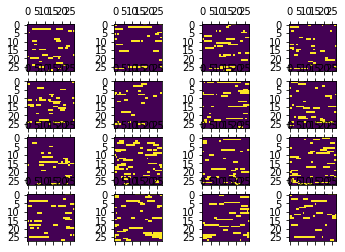

In [6]:
fig, axs = plt.subplots(4, 4)
for i in range(16):
    axs[i // 4, i % 4].matshow(np.reshape(sample_N_gram(5, five_gram, 28 * 28), (28, 28)))

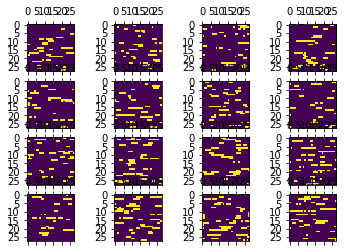

In [7]:
fig, axs = plt.subplots(4, 4)
for i in range(16):
    axs[i // 4, i % 4].matshow(np.reshape(sample_N_gram(5, five_gram, 28 * 28), (28, 28)))